##Downloading Dataset

#Importing the Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from skimage.io import imread
from skimage.transform import rescale
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from keras.layers import Input, UpSampling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, InceptionV3, MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.preprocessing import image
import os
sns.set()

##Loading Training Data

In [2]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     width_shift_range = 0.1,
     height_shift_range = 0.1,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "archive/train",
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical',
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

##Loading Test Dataset

In [3]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "archive/test",
                                           target_size=(128,128),
                                           batch_size=32,
                                           class_mode='categorical',
                                  )

val_data.class_indices

Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

#Visualization of Emotion Category Distribution in Training Data

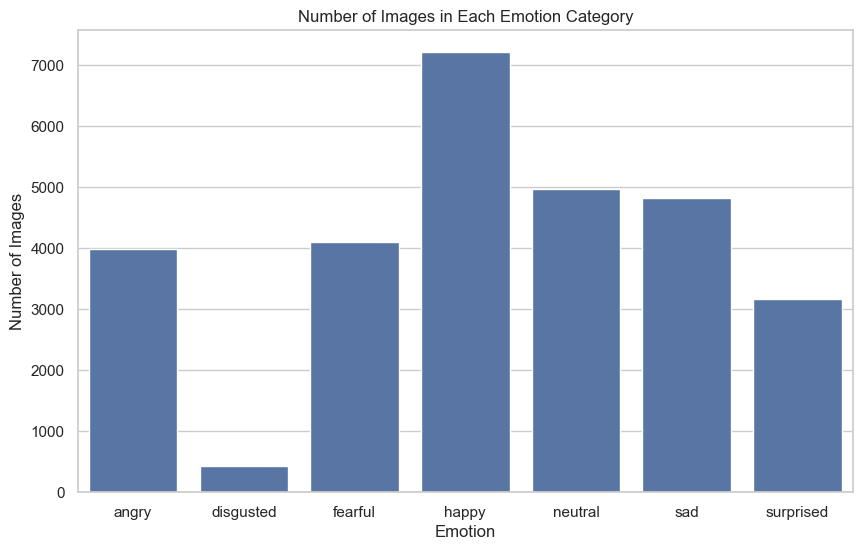

In [4]:
path = 'archive/train'

emotions = os.listdir(path)

folder_names = []
counts = []

for emotion in emotions:
    emotion_path = os.path.join(path, emotion)
    num_images = len(os.listdir(emotion_path))

    folder_names.append(emotion)
    counts.append(num_images)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=folder_names, y=counts)
ax.set(xlabel='Emotion', ylabel='Number of Images')
plt.title('Number of Images in Each Emotion Category')
plt.show()

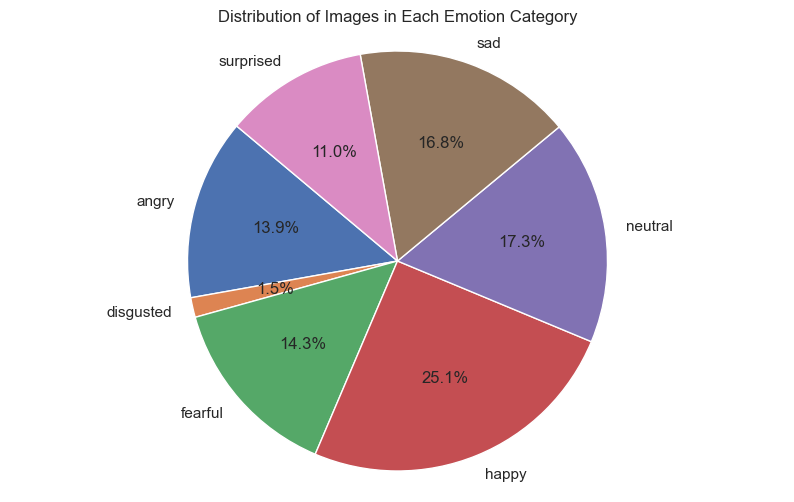

In [5]:
plt.figure(figsize=(10, 6))
plt.pie(counts, labels=folder_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images in Each Emotion Category')
plt.axis('equal')
plt.show()

#Visualization of Sample Images from Training Data

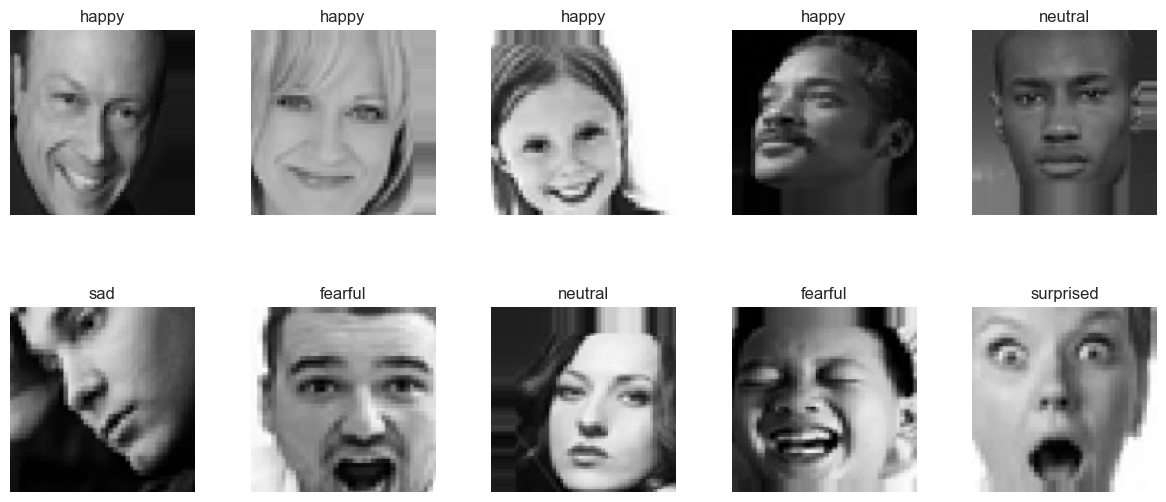

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you are using Keras or TensorFlow's DirectoryIterator
iterator = iter(train_data)  # Create an iterator from the DirectoryIterator
t_img, label = next(iterator)  # Get the next batch of images and labels

def plotImages(img_arr, one_hot_labels, label_names, images_to_show=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust size for 10 images
    fig.subplots_adjust(hspace=0.5)

    for i, (im, one_hot_label) in enumerate(zip(img_arr, one_hot_labels)):
        label_index = np.argmax(one_hot_label)
        label_name = label_names[label_index]

        ax = axes[i // 5, i % 5]
        ax.imshow(im)
        ax.set_title(label_name)
        ax.axis('off')

        if i == images_to_show - 1:
            break

# Assuming these labels correspond to your dataset
label_names = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Plot the images
plotImages(t_img, label, label_names, images_to_show=10)


#Deep Learning

## Traansfer Learning(TL)

###MobileNet-based CNN Model

In [7]:
base_model = MobileNet( weights = 'imagenet', input_shape = (128,128,3), include_top = False )

x = base_model.output
x= Conv2D(filters = 32, kernel_size = (1,1), strides = (1,1), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(units = 256 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units = 512 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units=7 , activation = 'softmax' )(x)

model = Model(base_model.input, outputs = x)

model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy']  )
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 5,095,847 (19.44 MB)

 Trainable params: 5,073,959 (19.36 MB)

 Non-trainable params: 21,888 (85.50 KB)

###Model Training with Callbacks

In [8]:
checkpoint = ModelCheckpoint(filepath="best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [9]:
hist = model.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list, verbose=2)

f:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.40318, saving model to best_model.keras
898/898 - 833s - 928ms/step - accuracy: 0.4156 - loss: 1.4896 - val_accuracy: 0.4032 - val_loss: 1.4984 - learning_rate: 0.0010
Epoch 2/25

Epoch 2: val_accuracy improved from 0.40318 to 0.53970, saving model to best_model.keras
898/898 - 628s - 699ms/step - accuracy: 0.5082 - loss: 1.3076 - val_accuracy: 0.5397 - val_loss: 1.2554 - learning_rate: 0.0010
Epoch 3/25

Epoch 3: val_accuracy improved from 0.53970 to 0.55851, saving model to best_model.keras
898/898 - 625s - 696ms/step - accuracy: 0.5449 - loss: 1.2129 - val_accuracy: 0.5585 - val_loss: 1.1582 - learning_rate: 0.0010
Epoch 4/25

Epoch 4: val_accuracy did not improve from 0.55851
898/898 - 623s - 694ms/step - accuracy: 0.5718 - loss: 1.1527 - val_accuracy: 0.5294 - val_loss: 1.2098 - learning_rate: 0.0010
Epoch 5/25

Epoch 5: val_accuracy improved from 0.55851 to 0.57551, saving model to best_model.keras
898/898 - 625s - 696ms/s

In [10]:
model.save('Emotion_Detection.keras')
#model = load_model('/content/drive/MyDrive/Colab_Notebooks/DL Model/Emotion_Detection.h5')

###Training and Validation Metrics Visualization

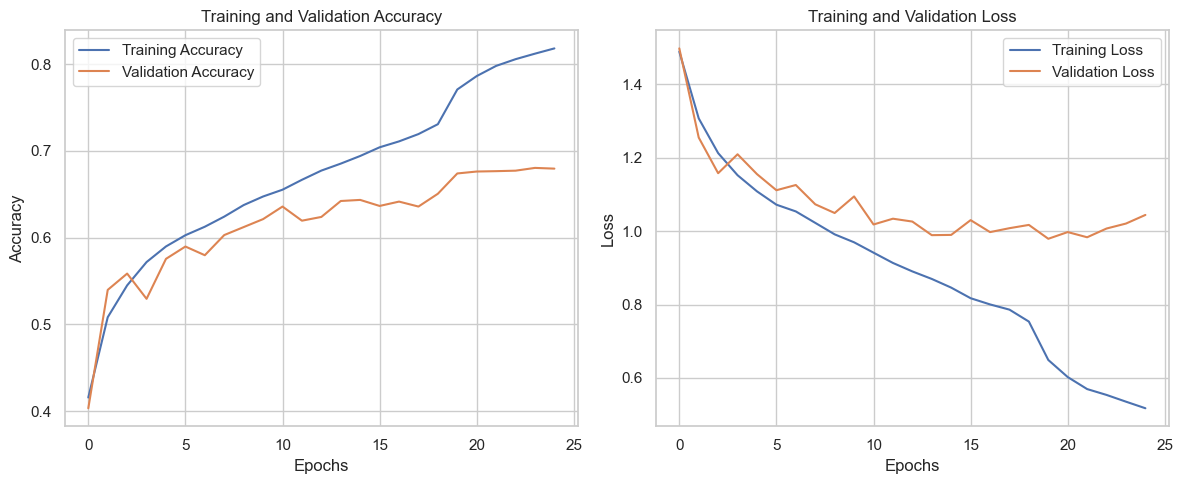

In [11]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

###Evaluation of the Model

In [12]:
results = model.evaluate(val_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - accuracy: 0.6765 - loss: 0.9685
Test results - Loss: 0.98 - Accuracy: 67.4%


###Model Prediction on Test Images

In [13]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprised'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
archive/test/neutral/im0.png 
The image is of neutral.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
archive/test/disgusted/im0.png 
The image is of disgusted.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
archive/test/angry/im0.png 
The image is of neutral.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
archive/test/fearful/im0.png 
The image is of fearful.



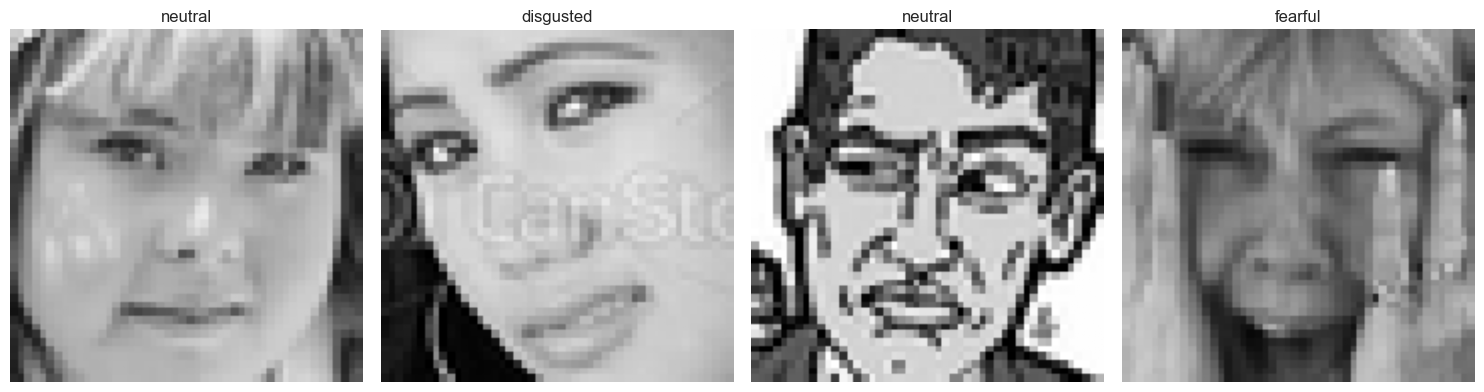

In [14]:
image_paths = [
    'archive/test/neutral/im0.png',
    'archive/test/disgusted/im0.png',
    'archive/test/angry/im0.png',
    'archive/test/fearful/im0.png'
]

num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, path in enumerate(image_paths):
    img = load_img(path, target_size=(128, 128))
    img_arr = img_to_array(img) / 255
    input_arr = np.array([img_arr])
    pred = np.argmax(model.predict(input_arr))
    print(f"{path} \nThe image is of {op[pred]}.\n")

    axs[i].imshow(img_arr)
    axs[i].set_title(op[pred])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

##Convolutional Neural Network (CNN)

###CNN Model

In [15]:
model_cnn = Sequential()

model_cnn.add(Conv2D(filters = 128, kernel_size = (1,1), input_shape = [128,128,3]))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 256, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 512, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Flatten())

model_cnn.add(Dense(units = 256))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 512))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 1024))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 7, activation = 'softmax'))

model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_cnn.summary()

f:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 29, 29, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,830,279 (106.16 MB)

 Trainable params: 27,830,279 (106.16 MB)

 Non-trainable params: 0 (0.00 B)

###Model Training with Callbacks

In [18]:
hist_cnn = model_cnn.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list, verbose=2)

Epoch 1/25

Epoch 1: val_accuracy did not improve from 0.68041
898/898 - 1525s - 2s/step - accuracy: 0.4852 - loss: 1.3321 - val_accuracy: 0.5135 - val_loss: 1.2654 - learning_rate: 0.0010
Epoch 2/25

Epoch 2: val_accuracy did not improve from 0.68041
898/898 - 1527s - 2s/step - accuracy: 0.5013 - loss: 1.3041 - val_accuracy: 0.5035 - val_loss: 1.3000 - learning_rate: 0.0010
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.68041
898/898 - 1534s - 2s/step - accuracy: 0.5020 - loss: 1.2912 - val_accuracy: 0.5300 - val_loss: 1.2408 - learning_rate: 0.0010
Epoch 4/25

Epoch 4: val_accuracy did not improve from 0.68041
898/898 - 1537s - 2s/step - accuracy: 0.5107 - loss: 1.2732 - val_accuracy: 0.5242 - val_loss: 1.2349 - learning_rate: 0.0010
Epoch 5/25

Epoch 5: val_accuracy did not improve from 0.68041
898/898 - 1536s - 2s/step - accuracy: 0.5185 - loss: 1.2576 - val_accuracy: 0.5208 - val_loss: 1.2474 - learning_rate: 0.0010
Epoch 6/25

Epoch 6: val_accuracy did not improve from 

###Training and Validation Metrics Visualization

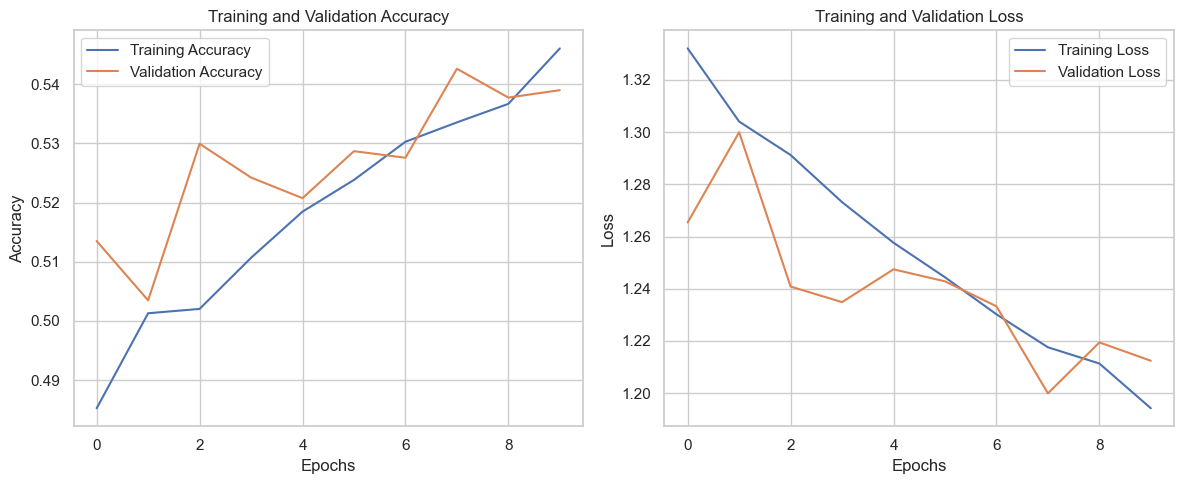

In [20]:
train_acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']
train_loss = hist_cnn.history['loss']
val_loss = hist_cnn.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

###Evaluation of the Model on Validation Data

In [21]:
results = model_cnn.evaluate(val_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

225/225 ━━━━━━━━━━━━━━━━━━━━ 87s 387ms/step - accuracy: 0.5206 - loss: 1.2502
Test results - Loss: 1.27 - Accuracy: 51.35%


###Model Prediction on Test Images

In [22]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprised'}


{0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprised'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
archive/test/neutral/im0.png 
The image is of neutral.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
archive/test/disgusted/im0.png 
The image is of happy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
archive/test/angry/im0.png 
The image is of fearful.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
archive/test/fearful/im0.png 
The image is of fearful.



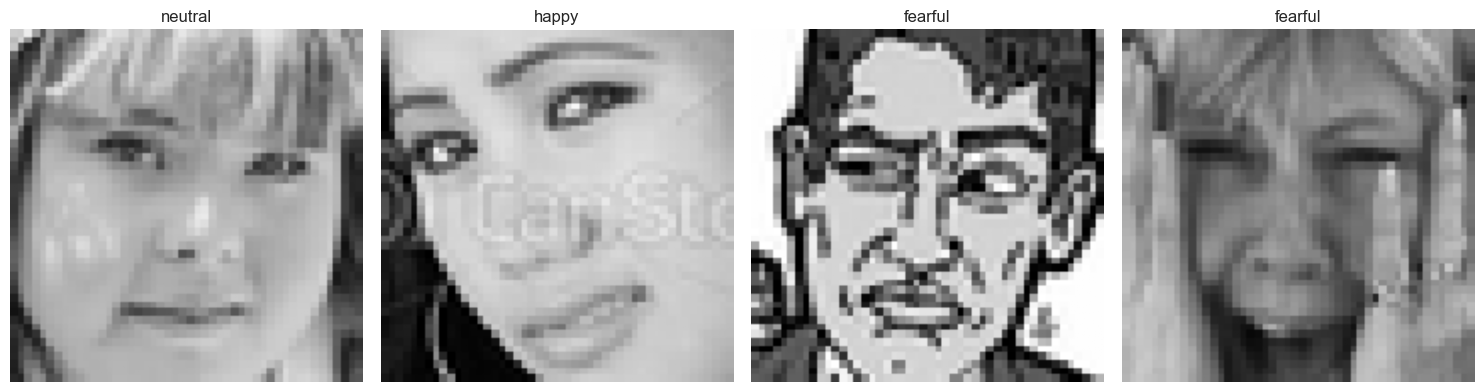

In [23]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

image_paths = [
    'archive/test/neutral/im0.png',
    'archive/test/disgusted/im0.png',
    'archive/test/angry/im0.png',
    'archive/test/fearful/im0.png'
]

num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, path in enumerate(image_paths):
    img = load_img(path, target_size=(128, 128))
    img_arr = img_to_array(img) / 255
    input_arr = np.array([img_arr])
    pred = np.argmax(model_cnn.predict(input_arr))
    print(f"{path} \nThe image is of {op[pred]}.\n")

    axs[i].imshow(img_arr)
    axs[i].set_title(op[pred])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

#Real-time Emotion Detection using a Webcam (Doesn't work on Colab but works on a local device)

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load the face classifier and emotion detection model
face_classifier = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')
classifier = load_model(r'Emotion_Detection.keras')

# Emotion labels
emotion_labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Start video capture
cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
        roi_gray = gray[y:y + h, x:x + w]
        # Resize to 128x128 to match the model input
        roi_gray = cv2.resize(roi_gray, (128, 128), interpolation=cv2.INTER_AREA)
        roi = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)  # Convert to RGB
        roi = roi.astype('float') / 255.0  # Normalize pixel values
        roi = np.expand_dims(roi, axis=0)  # Add batch dimension

        # Make prediction
        prediction = classifier.predict(roi)[0]
        label = emotion_labels[prediction.argmax()]  # Get the emotion label
        label_position = (x, y - 10)  # Position the label above the rectangle
        cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the video feed
    cv2.imshow('Emotion Detector', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

: 